In [0]:
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from drawing_utils import read_classes, draw_boxes, scale_boxes

%matplotlib inline

In [0]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """ Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        box_confidence -- np.array of shape (19, 19, 5, 1)
        boxes -- np.array of shape (19, 19, 5, 4)
        box_class_probs -- np.array of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
            then get rid of the corresponding box
    
    Returns:
        scores -- np.array of shape (None,), containing the class probability score for selected boxes
        boxes -- np.array of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- np.array of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """

    # Step 1: Compute box scores
    scores = box_confidence * box_class_probs
          
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    max_box_class = np.argmax(scores, axis=-1)
    max_box_score = np.amax(scores, axis=-1)
    
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    mask = max_box_score > threshold
    
    
    # Step 4: Apply the mask to scores, boxes and classes
    
    return max_box_score[mask], boxes[mask,:], max_box_class[mask]

In [12]:
#DO NOT EDIT THIS CODE
np.random.seed(0)
box_confidence = np.random.normal(size=(19, 19, 5, 1), loc=1, scale=4)
boxes = np.random.normal(size=(19, 19, 5, 4), loc=1, scale=4)
box_class_probs = np.random.normal(size=(19, 19, 5, 80), loc=1, scale=4)
scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2]))
print("boxes[2] = " + str(boxes[2]))
print("classes[2] = " + str(classes[2]))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 54.01492488333001
boxes[2] = [-1.92142838 -2.04944615 -4.78776134 11.48229538]
classes[2] = 8
scores.shape = (1790,)
boxes.shape = (1790, 4)
classes.shape = (1790,)


**Expected Output**:

| Variable          | Value       |
| ----------------- | ----------- |
| **scores[2]**     | 54.0149     |
| **boxes[2]**      | [-1.92142838 -2.04944615 -4.78776134 11.48229538] |
| **classes[2]**    | 8           |
| **scores.shape**  | (1790,)        |
| **boxes.shape**   | (1790, 4)      |
| **classes.shape** | (1790,)       |

In [0]:
def iou(prediction_box, gt_box):
    """Implement the intersection over union (IoU) between box1 and box2
    
    dx = min(prediction_box[xmax], gt_box[xmax]) - max(prediction_box[xmin], gt_box[xmin])
    dy = min(prediction_box[ymax], gt_box[ymax]) - max(prediction_box[ymin], gt_box[ymin])

    if (dx>0) and (dy>0): 
        intersection = float(dx*dy)
    else: 
        intersection = 0
    
    area_prediction_box = (prediction_box[xmax]-prediction_box[xmin])*(prediction_box[ymax]-prediction_box[ymin])
    area_gt_box = (gt_box[xmax]-gt_box[xmin])*(gt_box[ymax]-gt_box[ymin])

    union = float(area_prediction_box + area_gt_box - intersection)

    iou = intersection/union
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """
    xmin, ymin, xmax, ymax = 0,1,2,3
    
    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    
    
    dx = min(prediction_box[xmax], gt_box[xmax]) - max(prediction_box[xmin], gt_box[xmin])
    dy = min(prediction_box[ymax], gt_box[ymax]) - max(prediction_box[ymin], gt_box[ymin])
    
    intersection = float(dx*dy)
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    
    area_prediction_box = (prediction_box[xmax]-prediction_box[xmin])*(prediction_box[ymax]-prediction_box[ymin])
    area_gt_box = (gt_box[xmax]-gt_box[xmin])*(gt_box[ymax]-gt_box[ymin])

    union = float(area_prediction_box + area_gt_box - intersection)
    
    # compute the IoU
    
    iou = intersection/union

    return iou

In [14]:
#DO NOT EDIT THIS CODE
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


**Expected Output**:

| Variable          | Value               |
| ----------------- | ------------------- |
| **iou**           | 0.14285714285714285 |


In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
        scores -- np.array of shape (None,), output of yolo_filter_boxes()
        boxes -- np.array of shape (None, 4), output of yolo_filter_boxes() 
            that have been scaled to the image size (see later)
        classes -- np.array of shape (None,), output of yolo_filter_boxes()
        max_boxes -- integer, maximum number of predicted boxes you'd like
        iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. 
    Note also that this function will transpose the shapes of scores, boxes, classes. 
    This is made for convenience.
    """
    
    nms_indices = []
    idx_sort = np.argsort(scores)
    idx_sort = np.flip(idx_sort, axis=0)
    
    #print("Scores: {}".format(scores))
    #print("idx_sort: {}".format(idx_sort))
   
 
    while((len(idx_sort)>0) and (len(nms_indices) < max_boxes)):
      
      #print("idx_sort length: {}".format(len(idx_sort)))
      remove_set = []
      max_score_idx = idx_sort[0]
      nms_indices.append(max_score_idx)
      
      for i in range(idx_sort.shape[0]):
        iou_i = iou(boxes[max_score_idx], boxes[idx_sort[i]])
        #print("iou: {}".format(iou_i))
        if (iou_i > iou_threshold):
          remove_set.append(i)
      
      #print("Remove Set: {}".format(remove_set))
      idx_sort = np.delete(idx_sort, remove_set, axis=0)
    
          
          
    # Use iou() to get the list of indices corresponding to boxes you keep
    
    # Use index arrays to select only nms_indices from scores, boxes and classes
    
    return scores[nms_indices], boxes[nms_indices], classes[nms_indices]

In [16]:
#DO NOT EDIT THIS CODE
np.random.seed(0)
scores = np.random.normal(size=(54,), loc=1, scale=4)
boxes = np.random.normal(size=(54,4), loc=1, scale=4)
classes = np.random.normal(size=(54,), loc=1, scale=4)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
print("scores[2] = " + str(scores[2]))
print("boxes[2] = " + str(boxes[2]))
print("classes[2] = " + str(classes[2]))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 8.803101580927159
boxes[2] = [ 1.62602615  1.92872414 -1.38926428  0.04831308]
classes[2] = -1.9227110114592993
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

| Variable          | Value       |
| ----------------- | ----------- |
| **scores[2]**     | 8.8031      |
| **boxes[2]**      | [ 1.62602615  1.92872414 -1.38926428  0.04831308] |
| **classes[2]**    | -1.9227     |
| **scores.shape**  | (10,)       |
| **boxes.shape**   | (10, 4)     |
| **classes.shape** | (10,)       |

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
        yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 np.array:
                        box_confidence: tensor of shape (None, 19, 19, 5, 1)
                        boxes: tensor of shape (None, 19, 19, 5, 4)
                        box_class_probs: tensor of shape (None, 19, 19, 5, 80)
        image_shape -- np.array of shape (2,) containing the input shape, in this notebook we use 
            (608., 608.) (has to be float32 dtype)
        max_boxes -- integer, maximum number of predicted boxes you'd like
        score_threshold -- real value, if [ highest class probability score < threshold], 
            then get rid of the corresponding box
        iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
        scores -- np.array of shape (None, ), predicted score for each box
        boxes -- np.array of shape (None, 4), predicted box coordinates
        classes -- np.array of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence = yolo_outputs[0]
    boxes = yolo_outputs[1]
    box_class_probs = yolo_outputs[2]
       
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold) 
    
    # Scale boxes back to original image shape.
    
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, iou_threshold = iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [18]:
#DO NOT EDIT THIS CODE
np.random.seed(0)
yolo_outputs = (np.random.normal(size=(19, 19, 5, 1,), loc=1, scale=4),
                np.random.normal(size=(19, 19, 5, 4,), loc=1, scale=4),
                np.random.normal(size=(19, 19, 5, 80,), loc=1, scale=4))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2]))
print("boxes[2] = " + str(boxes[2]))
print("classes[2] = " + str(classes[2]))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 143.33886713132935
boxes[2] = [ 1366.07098516  7609.25352373  1133.27145691 -9957.2042546 ]
classes[2] = 79
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:

| Variable          | Value       |
| ----------------- | ----------- |
| **scores[2]**     | 143.33886713132935     |
| **boxes[2]**      | [ 1366.07098516  7609.25352373  1133.27145691 -9957.2042546 ] |
| **classes[2]**    | 79          |
| **scores.shape**  | (10,)       |
| **boxes.shape**   | (10, 4)     |
| **classes.shape** | (10,)       |

In [0]:
# DO NOT CHANGE
image = Image.open("test.jpg")
box_confidence = np.load("box_confidence.npy")
boxes = np.load("boxes.npy")
box_class_probs = np.load("box_class_probs.npy")
yolo_outputs = (box_confidence, boxes, box_class_probs)

In [0]:
# DO NOT CHANGE
image_shape = (720., 1280.)

In [0]:
#DO NOT EDIT THIS CODE
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, image_shape)

Found 7 boxes
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


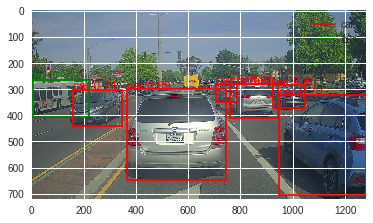

In [23]:
#DO NOT EDIT THIS CODE
# Print predictions info
print('Found {} boxes'.format(len(out_boxes)))
# Draw bounding boxes on the image
draw_boxes(image, out_scores, out_boxes, out_classes)
# Display the results in the notebook
imshow(image)
import matplotlib.pyplot as plt

**Expected Output**:

**Found 7 boxes**

| Object            | Confidence| position| size  |
| ----------------- | ----------|---------|-------- |
| **car**           | 0.60| (925, 285) |(1045, 374) |
| **car**           | 0.66 |(706, 279) |(786, 350)  |
| **bus**           | 0.67| (5, 266)| (220, 407)    |
| **car**           | 0.70 |(947, 324) |(1280, 705) |
| **car**           | 0.74 |(159, 303) |(346, 440)  |
| **car**           | 0.80 |(761, 282) |(942, 412)  |
| **car**           | 0.89 |(367, 300) |(745, 648)  |